# MPC Surrogate Training Pipeline

This notebook implements the complete training and evaluation pipeline for approximating MPC policies using neural networks.

## Dataset Structure
- **States**: Joint positions and velocities (6D) - [q1, q2, q3, q̇1, q̇2, q̇3]
- **Targets**: End-effector target positions (3D) - [x, y, z]
- **Actions**: MPC torques (3D) - [τ1, τ2, τ3]

The goal is to learn a mapping: (state, target) → MPC torques

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import json
import os
from tqdm import tqdm
import time
import copy
from torch.nn.utils.rnn import pad_sequence
import random

def compute_direction_accuracy(y_true, y_pred):
    """
    Sum the number of time the sign of the predicted torque matches the true torque.
    """
    return np.sum(np.sign(y_true) == np.sign(y_pred)) / (3 * len(y_true))

torch.manual_seed(42)
np.random.seed(42)

#INPUT_DIR = '/'
INTPUT_DIR = "/kaggle/input/robot-mpc-dataset/"
#OUTPUT_DIR="/"
OUTPUT_DIR="/kaggle/working"

DATA_PATH = os.path.join(INTPUT_DIR, "robot_mpc_dataset.h5")
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


## Data Preparation

In [2]:
class MPCDataset(Dataset):
    def __init__(self, filepath, episode_keys, mode="mlp", augment=False):
        """
        mode: 'mlp' (flattens trajectories) or 'rnn' (keeps trajectories intact)
        """
        super().__init__()
        self.augment = augment
        self.mode = mode
        self.data = []  # (inputs, actions) tuples

        with h5py.File(filepath, "r") as f:
            grp_eps = f["episodes"]
            for ep in episode_keys:
                s = torch.from_numpy(grp_eps[ep]["states"][:]).float()  # (T, 6)
                t = torch.from_numpy(grp_eps[ep]["targets"][:]).float()  # (T, 3)
                a = torch.from_numpy(grp_eps[ep]["actions"][:]).float()  # (T, 3)

                # states + targets as input -> (T, 9)
                inp = torch.cat([s, t], dim=-1)
                self.data.append((inp, a))

        # if MLP, flatten all steps from these specific episodes into one tensor
        if self.mode == "mlp":
            self.inputs = torch.cat([x[0] for x in self.data], dim=0)
            self.actions = torch.cat([x[1] for x in self.data], dim=0)

    def __len__(self):
        return len(self.inputs) if self.mode == "mlp" else len(self.data)

    def __getitem__(self, idx):
        if self.mode == "mlp":
            x, y = self.inputs[idx], self.actions[idx]  # (9,), (3,)
            if self.augment:
                x[:6] += torch.randn(6) * 0.01  # noise on state
                y += torch.randn(3) * 0.005  # noise on action
            return x, y
        else:
            x, y = self.data[idx]  # (T, 9), (T, 3)
            if self.augment:
                noise_x = torch.randn_like(x)
                noise_x[:, 6:] = 0  # no noise on targets
                x = x + (noise_x * 0.01)
                y = y + (torch.randn_like(y) * 0.005)
            return x, y


def collate_rnn(batch):
    inputs, actions = zip(*batch)
    lengths = torch.tensor([x.size(0) for x in inputs])

    # pad variable lengths (T0, T1...) to max length in batch
    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T_max, 9)
    padded_actions = pad_sequence(actions, batch_first=True)  # (B, T_max, 3)

    return padded_inputs, padded_actions, lengths

def create_dataloaders(filepath, train_ratio=0.8, val_ratio=0.1, batch_size=32, dataset_type="mlp"):
    """
    Creates Train (80%), Validation (10%), and Test (10%) dataloaders.
    """
    with h5py.File(filepath, "r") as f:
        keys = np.array(sorted(f["episodes"].keys()))
        if dataset_type == "mlp":
          # we figured out during scaling experiment only 50% of the dataset if sufficient
          truncated_len = int(len(keys) * 0.5)
          keys = keys[:truncated_len]

    np.random.shuffle(keys)

    n_total = len(keys)
    train_end = int(n_total * train_ratio)
    val_end = int(n_total * (train_ratio + val_ratio))

    train_keys = keys[:train_end]
    val_keys = keys[train_end:val_end]
    test_keys = keys[val_end:]  # remainder (approx 10%)

    if dataset_type == "mlp":
        # train: Augment = True
        train_ds = MPCDataset(filepath, train_keys, mode="mlp", augment=True)
        # val/test: Augment = False
        val_ds = MPCDataset(filepath, val_keys, mode="mlp", augment=False)
        test_ds = MPCDataset(filepath, test_keys, mode="mlp", augment=False)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    elif dataset_type == "rnn":
        train_ds = MPCDataset(filepath, train_keys, mode="rnn", augment=True)
        val_ds = MPCDataset(filepath, val_keys, mode="rnn", augment=False)
        test_ds = MPCDataset(filepath, test_keys, mode="rnn", augment=False)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_rnn, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    print(f"Split sizes: Train={len(train_keys)}, Val={len(val_keys)}, Test={len(test_keys)}")

    return train_dl, val_dl, test_dl

# Data vizualization

Visualizing episode 1425


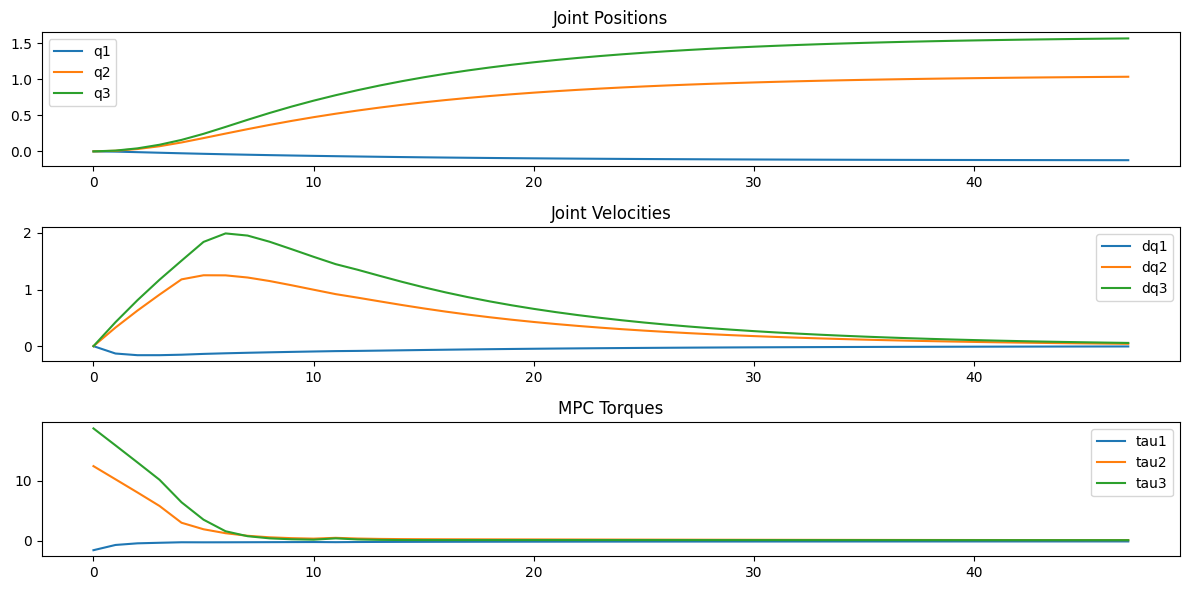

In [3]:
episodes = []
with h5py.File(DATA_PATH, "r") as f:
    keys = np.array(sorted(f["episodes"].keys()))
    for ep in keys:
        grp = f["episodes"][ep]
        states = grp["states"][:]
        targets = grp["targets"][:]
        actions = grp["actions"][:]
        episodes.append((states, targets, actions))

# pick a random episode
ep_idx = random.randint(0, len(episodes) - 1)
episode = episodes[ep_idx]
ep_states = episode[0]
ep_targets = episode[1]
ep_actions = episode[2]

print(f"Visualizing episode {ep_idx}")

# joint positions
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(ep_states[:, 0], label="q1")
plt.plot(ep_states[:, 1], label="q2")
plt.plot(ep_states[:, 2], label="q3")
plt.title("Joint Positions")
plt.legend()

# joint velocities
plt.subplot(3, 1, 2)
plt.plot(ep_states[:, 3], label="dq1")
plt.plot(ep_states[:, 4], label="dq2")
plt.plot(ep_states[:, 5], label="dq3")
plt.title("Joint Velocities")
plt.legend()

# MPC actions
plt.subplot(3, 1, 3)
plt.plot(ep_actions[:, 0], label="tau1")
plt.plot(ep_actions[:, 1], label="tau2")
plt.plot(ep_actions[:, 2], label="tau3")
plt.title("MPC Torques")
plt.legend()

plt.tight_layout()
plt.show()


## Model Architectures

In [4]:
class MLP(nn.Module):
    """Simple Multi-Layer Perceptron"""
    def __init__(self, input_dim=9, hidden_dims=[128, 64], output_dim=3):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class GRU(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2, output_dim=3):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths=None):
        # x: (B, T, 9)
        if lengths is not None:
            lengths_cpu = lengths.cpu()
            x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths_cpu, batch_first=True, enforce_sorted=False)
            out_packed, hn = self.gru(x_packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            out, hn = self.gru(x) # (B, T_max, 3)

        out = self.fc(out)
        return out

## Training and Evaluation Functions

In [5]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch in train_loader:
        if len(batch) == 3: # RNN
            inputs, targets, lengths = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs, lengths)

            # Masking
            mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
            mask = mask.unsqueeze(-1).expand_as(targets)

            loss_raw = criterion(outputs, targets)
            loss = (loss_raw * mask).sum() / mask.sum()

        else: # MLP
            inputs, targets = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            loss_raw = criterion(outputs, targets)
            loss = loss_raw.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def evaluate(model, test_loader, criterion):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0
    num_batches = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 3: #RNN
                inputs, targets, lengths = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs, lengths)

                # Masking
                mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
                mask = mask.unsqueeze(-1).expand_as(targets)

                loss_raw = criterion(outputs, targets)
                loss = (loss_raw * mask).sum() / mask.sum()

                # Filter predictions and targets for metrics
                # We flatten and remove padded values
                outputs_masked = outputs[mask].view(-1, 3)
                targets_masked = targets[mask].view(-1, 3)

                all_predictions.append(outputs_masked.cpu().numpy())
                all_targets.append(targets_masked.cpu().numpy())

            else:
                inputs, targets = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss_raw = criterion(outputs, targets)
                loss = loss_raw.mean()

                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

            total_loss += loss.item()
            num_batches += 1

    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)

    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
        targets = targets.reshape(-1, targets.shape[-1])

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    da = compute_direction_accuracy(targets, predictions)
    ev = explained_variance_score(targets, predictions)
    mse_per_torque = mean_squared_error(targets, predictions, multioutput="raw_values")

    return {
        'loss': total_loss / num_batches,
        'mse': mse,
        'mae': mae,
        'direction_accuracy': da,
        'explained_variance': ev,
        'predictions': predictions,
        'targets': targets,
        'mse_per_torque': mse_per_torque
    }

In [6]:
def train_model(model_name, model, train_loader, test_loader, validation_loader,
                loss_type="mse", num_epochs=50, trial=0):
    if loss_type == "mse":
        criterion = nn.MSELoss(reduction='none')
    elif loss_type == "mae":
        criterion = nn.L1Loss(reduction='none')
    else:
        raise ValueError("loss_type must be 'mse' or 'mae'")

    # keep track of both for reporting, but only optimize 'criterion'
    monitor_mse = nn.MSELoss(reduction='none')
    monitor_mae = nn.L1Loss(reduction='none')

    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    results = {
        'model_name': model_name,
        'loss_type': loss_type,
        'training_history': [],
        'best_results': None,
    }

    best_val_loss = float('inf')
    pbar = tqdm(range(num_epochs), desc=f"Training {model_name}")

    try:
        for epoch in pbar:
            start_time = time.time()

            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            val_metrics = evaluate(model, validation_loader, criterion)

            epoch_time = time.time() - start_time

            pbar.set_postfix({
                "loss": f"{val_metrics['loss']:.4f}",
                "mse": f"{val_metrics['mse']:.4f}",
                "mae": f"{val_metrics['mae']:.4f}"
            })

            results['training_history'].append({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_metrics['loss'],
                'val_mse': val_metrics['mse'],
                'val_mae': val_metrics['mae'],
                'val_da': val_metrics['direction_accuracy'],
                'val_ev': val_metrics['explained_variance'],
                'val_mse_per_torque': val_metrics['mse_per_torque'],
                'epoch_time': epoch_time
            })

            # save best model based on the chosen loss_type
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                results['best_results'] = val_metrics.copy()
                results['best_results'].pop('predictions', None)
                results['best_results'].pop('targets', None)
                model_output_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pth')
                torch.save(model.state_dict(), model_output_path)

    except KeyboardInterrupt:
        print("\nInterrupted.")
    finally:
        # save the results of the best model on the test set
        best_model_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pth')
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path))
            final_test_metrics = evaluate(model, test_loader, criterion)

            final_test_metrics.pop('predictions', None)
            final_test_metrics.pop('targets', None)
            results['final_test_results'] = final_test_metrics

            print(f"Final Test MSE: {final_test_metrics['mse']:.5f}")
        else:
            print("failed opening best model")

        json_str = json.dumps(results, indent=2, default=lambda x: float(x) if isinstance(x, (np.floating, torch.Tensor)) else str(x))
        results_output_path = os.path.join(RESULTS_DIR, f'{model_name}_best_{loss_type}_{trial}_results.json')
        with open(results_output_path, 'w') as f:
            f.write(json_str)

    return results

# Experiment setup

In [7]:
def run_experiment_repeated(model_name, model_class, params, dataset_type, loss_type, n_runs=5, n_epochs=50):
    """Runs a specific configuration N times and aggregates metrics."""
    print(f"\n>>> EXPERIMENT: {model_name} | Loss: {loss_type} | Runs: {n_runs}")

    aggregated_metrics = {
        'mse': [], 'mae': [], 'direction_accuracy': [], 'explained_variance': []
    }

    for i in range(n_runs):
        print(f"   Run {i+1}/{n_runs}...", end=" ")

        train_dl, val_dl, test_dl = create_dataloaders(DATA_PATH, batch_size=64, dataset_type=dataset_type)
        model = model_class(**params).to(DEVICE)

        res = train_model(model_name, model, train_dl, val_dl, test_dl, loss_type=loss_type, num_epochs=n_epochs, trial=i+1)

        best = res['best_results']
        aggregated_metrics['mse'].append(best['mse'])
        aggregated_metrics['mae'].append(best['mae'])
        aggregated_metrics['direction_accuracy'].append(best['direction_accuracy'])
        aggregated_metrics['explained_variance'].append(best['explained_variance'])
        print(f"Done. (MSE: {best['mse']:.4f})")

    stats = {}
    for metric, values in aggregated_metrics.items():
        stats[f'{metric}_mean'] = np.mean(values)
        stats[f'{metric}_std']  = np.std(values)

    print(f"   >>> {model_name} Finished. Avg MSE: {stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}")
    return stats

## Loss comparison

In [8]:
loss_configs = {
    'MLP': {'class': MLP, 'params': {'hidden_dims': [128, 64]}, 'dataset_type': 'mlp'},
    'GRU': {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn'},
}

loss_types = ['mse', 'mae']
loss_results = {}

for name, config in loss_configs.items():
    for loss in loss_types:
        run_name = f"{name}_{loss}"
        stats = run_experiment_repeated(
            model_name=run_name,
            model_class=config['class'],
            params=config['params'],
            dataset_type=config['dataset_type'],
            loss_type=loss,
            n_runs=5,
            n_epochs=50
        )
        loss_results[run_name] = stats

print("\n=== PHASE 1 RESULTS SUMMARY ===")
print(f"{'Model Config':<20} | {'MSE (Mean ± Std)':<25} | {'MAE (Mean ± Std)':<25}")
print("-" * 75)
for name, stats in loss_results.items():
    mse_str = f"{stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}"
    mae_str = f"{stats['mae_mean']:.4f} ± {stats['mae_std']:.4f}"
    print(f"{name:<20} | {mse_str:<25} | {mae_str:<25}")


>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mse: 100%|██████████| 50/50 [01:59<00:00,  2.39s/it, loss=0.2044, mse=0.2053, mae=0.1577]


Final Test MSE: 0.32554
Done. (MSE: 0.1734)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mse: 100%|██████████| 50/50 [02:00<00:00,  2.42s/it, loss=0.1804, mse=0.1805, mae=0.1840]


Final Test MSE: 0.12078
Done. (MSE: 0.1731)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mse: 100%|██████████| 50/50 [02:00<00:00,  2.40s/it, loss=0.1104, mse=0.1118, mae=0.2069]


Final Test MSE: 0.09656
Done. (MSE: 0.0931)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mse: 100%|██████████| 50/50 [02:00<00:00,  2.40s/it, loss=0.2195, mse=0.2210, mae=0.1981]


Final Test MSE: 0.21187
Done. (MSE: 0.2210)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mse: 100%|██████████| 50/50 [01:59<00:00,  2.39s/it, loss=0.2966, mse=0.2971, mae=0.2218]


Final Test MSE: 0.27938
Done. (MSE: 0.2351)
   >>> MLP_mse Finished. Avg MSE: 0.1791 ± 0.0497

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mae: 100%|██████████| 50/50 [01:58<00:00,  2.38s/it, loss=0.0827, mse=0.1107, mae=0.0838]


Final Test MSE: 0.20462
Done. (MSE: 0.1107)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mae: 100%|██████████| 50/50 [02:00<00:00,  2.41s/it, loss=0.0840, mse=0.1277, mae=0.0841]


Final Test MSE: 0.16646
Done. (MSE: 0.1277)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mae: 100%|██████████| 50/50 [02:00<00:00,  2.41s/it, loss=0.0840, mse=0.0896, mae=0.0846]


Final Test MSE: 0.17156
Done. (MSE: 0.0858)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mae: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it, loss=0.0867, mse=0.1514, mae=0.0877]


Final Test MSE: 0.23076
Done. (MSE: 0.1631)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_mae: 100%|██████████| 50/50 [02:01<00:00,  2.42s/it, loss=0.0939, mse=0.1957, mae=0.0943]


Final Test MSE: 0.13638
Done. (MSE: 0.2106)
   >>> MLP_mae Finished. Avg MSE: 0.1396 ± 0.0435

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [00:14<00:00,  3.40it/s, loss=1.2799, mse=1.2833, mae=0.2831]


Final Test MSE: 1.09225
Done. (MSE: 1.2833)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s, loss=1.2373, mse=1.2390, mae=0.2703]


Final Test MSE: 1.11715
Done. (MSE: 1.2390)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [00:14<00:00,  3.57it/s, loss=1.0473, mse=1.0414, mae=0.2531]


Final Test MSE: 0.91977
Done. (MSE: 1.0414)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [00:14<00:00,  3.53it/s, loss=1.1739, mse=1.1804, mae=0.2698]


Final Test MSE: 1.03018
Done. (MSE: 1.1804)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s, loss=1.1478, mse=1.1241, mae=0.2557]


Final Test MSE: 0.94695
Done. (MSE: 1.1241)
   >>> GRU_mse Finished. Avg MSE: 1.1737 ± 0.0852

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [00:14<00:00,  3.54it/s, loss=0.3488, mse=1.9973, mae=0.3466]


Final Test MSE: 1.99774
Done. (MSE: 2.0219)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [00:14<00:00,  3.56it/s, loss=0.3591, mse=2.2436, mae=0.3587]


Final Test MSE: 1.91045
Done. (MSE: 2.2436)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [00:13<00:00,  3.60it/s, loss=0.3563, mse=2.2033, mae=0.3576]


Final Test MSE: 2.27116
Done. (MSE: 2.2033)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [00:13<00:00,  3.59it/s, loss=0.3555, mse=2.1402, mae=0.3566]


Final Test MSE: 2.33534
Done. (MSE: 2.1402)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s, loss=0.3502, mse=1.9575, mae=0.3492]

Final Test MSE: 1.95896
Done. (MSE: 1.9894)
   >>> GRU_mae Finished. Avg MSE: 2.1197 ± 0.0993

=== PHASE 1 RESULTS SUMMARY ===
Model Config         | MSE (Mean ± Std)          | MAE (Mean ± Std)         
---------------------------------------------------------------------------
MLP_mse              | 0.1791 ± 0.0497           | 0.1786 ± 0.0191          
MLP_mae              | 0.1396 ± 0.0435           | 0.0841 ± 0.0023          
GRU_mse              | 1.1737 ± 0.0852           | 0.2664 ± 0.0109          
GRU_mae              | 2.1197 ± 0.0993           | 0.3510 ± 0.0082          


## Architecture comparison


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Small: 100%|██████████| 50/50 [02:03<00:00,  2.46s/it, loss=0.2572, mse=0.2603, mae=0.2394]


Final Test MSE: 0.36626
Done. (MSE: 0.2603)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Small: 100%|██████████| 50/50 [02:03<00:00,  2.47s/it, loss=0.2751, mse=0.2780, mae=0.1936]


Final Test MSE: 0.25731
Done. (MSE: 0.2780)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Small: 100%|██████████| 50/50 [02:02<00:00,  2.45s/it, loss=0.1956, mse=0.1964, mae=0.1879]


Final Test MSE: 0.18079
Done. (MSE: 0.1964)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Small: 100%|██████████| 50/50 [02:02<00:00,  2.45s/it, loss=0.2162, mse=0.2171, mae=0.2249]


Final Test MSE: 0.27082
Done. (MSE: 0.2077)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Small: 100%|██████████| 50/50 [02:02<00:00,  2.46s/it, loss=0.3084, mse=0.3124, mae=0.2439]


Final Test MSE: 0.23307
Done. (MSE: 0.2888)
   >>> MLP_Small Finished. Avg MSE: 0.2462 ± 0.0374

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Medium: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it, loss=0.1369, mse=0.1383, mae=0.1676]


Final Test MSE: 0.13917
Done. (MSE: 0.1380)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Medium: 100%|██████████| 50/50 [02:00<00:00,  2.42s/it, loss=0.0822, mse=0.0833, mae=0.1388]


Final Test MSE: 0.24202
Done. (MSE: 0.0751)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Medium: 100%|██████████| 50/50 [02:00<00:00,  2.42s/it, loss=0.1709, mse=0.1714, mae=0.1559]


Final Test MSE: 0.21182
Done. (MSE: 0.1618)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Medium: 100%|██████████| 50/50 [02:00<00:00,  2.42s/it, loss=0.1850, mse=0.1861, mae=0.2067]


Final Test MSE: 0.22068
Done. (MSE: 0.1745)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Medium: 100%|██████████| 50/50 [02:01<00:00,  2.42s/it, loss=0.1874, mse=0.1892, mae=0.1880]


Final Test MSE: 0.15676
Done. (MSE: 0.1676)
   >>> MLP_Medium Finished. Avg MSE: 0.1434 ± 0.0363

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Deep: 100%|██████████| 50/50 [02:11<00:00,  2.63s/it, loss=0.0563, mse=0.0562, mae=0.0861]


Final Test MSE: 0.03732
Done. (MSE: 0.0542)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Deep: 100%|██████████| 50/50 [02:14<00:00,  2.68s/it, loss=0.3587, mse=0.3604, mae=0.1225]


Final Test MSE: 0.03876
Done. (MSE: 0.0476)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Deep: 100%|██████████| 50/50 [02:13<00:00,  2.68s/it, loss=0.0430, mse=0.0433, mae=0.0892]


Final Test MSE: 0.20814
Done. (MSE: 0.0288)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Deep: 100%|██████████| 50/50 [02:15<00:00,  2.70s/it, loss=0.1973, mse=0.1990, mae=0.1140]


Final Test MSE: 0.04549
Done. (MSE: 0.0563)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86


Training MLP_Deep: 100%|██████████| 50/50 [02:14<00:00,  2.69s/it, loss=0.0852, mse=0.0859, mae=0.0727]


Final Test MSE: 0.03334
Done. (MSE: 0.0358)
   >>> MLP_Deep Finished. Avg MSE: 0.0445 ± 0.0106

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:12<00:00,  4.11it/s, loss=2.5650, mse=2.5411, mae=0.4135]


Final Test MSE: 2.76052
Done. (MSE: 2.5411)
   Run 2/5... 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:12<00:00,  4.14it/s, loss=2.7692, mse=2.7559, mae=0.4218]


Final Test MSE: 2.55072
Done. (MSE: 2.7559)
   Run 3/5... 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s, loss=2.6102, mse=2.6268, mae=0.4167]


Final Test MSE: 2.62677
Done. (MSE: 2.6268)
   Run 4/5... 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s, loss=2.5032, mse=2.4981, mae=0.4034]


Final Test MSE: 2.44496
Done. (MSE: 2.4981)
   Run 5/5... 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s, loss=2.6528, mse=2.6192, mae=0.4233]


Final Test MSE: 2.67957
Done. (MSE: 2.6192)
   >>> GRU_Shallow Finished. Avg MSE: 2.6082 ± 0.0882

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s, loss=0.8682, mse=0.8760, mae=0.2511]


Final Test MSE: 1.10477
Done. (MSE: 0.8760)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [00:14<00:00,  3.38it/s, loss=1.2449, mse=1.2506, mae=0.2719]


Final Test MSE: 1.26689
Done. (MSE: 1.2506)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [00:14<00:00,  3.39it/s, loss=1.0692, mse=1.0796, mae=0.2594]


Final Test MSE: 1.06379
Done. (MSE: 1.0796)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [00:14<00:00,  3.37it/s, loss=1.3527, mse=1.3524, mae=0.2760]


Final Test MSE: 1.12088
Done. (MSE: 1.3524)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s, loss=1.1609, mse=1.1455, mae=0.2619]


Final Test MSE: 1.27842
Done. (MSE: 1.1455)
   >>> GRU_Medium Finished. Avg MSE: 1.1408 ± 0.1617

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss=0.4370, mse=0.4422, mae=0.2108]


Final Test MSE: 0.53052
Done. (MSE: 0.4422)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, loss=0.6134, mse=0.6143, mae=0.2396]


Final Test MSE: 0.48220
Done. (MSE: 0.5755)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss=0.4554, mse=0.4567, mae=0.2047]


Final Test MSE: 0.65330
Done. (MSE: 0.4567)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss=0.5642, mse=0.5745, mae=0.2584]


Final Test MSE: 0.44639
Done. (MSE: 0.5322)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s, loss=0.4674, mse=0.4675, mae=0.2194]


Final Test MSE: 0.44833
Done. (MSE: 0.4675)
   >>> GRU_Deep Finished. Avg MSE: 0.4948 ± 0.0507

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [00:15<00:00,  3.30it/s, loss=0.6009, mse=0.6098, mae=0.1817]


Final Test MSE: 0.57165
Done. (MSE: 0.6098)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [00:15<00:00,  3.30it/s, loss=0.5139, mse=0.5329, mae=0.1480]


Final Test MSE: 0.31822
Done. (MSE: 0.5329)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [00:14<00:00,  3.35it/s, loss=0.5985, mse=0.5883, mae=0.1583]


Final Test MSE: 0.48652
Done. (MSE: 0.5883)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [00:15<00:00,  3.31it/s, loss=0.5910, mse=0.6051, mae=0.1589]


Final Test MSE: 0.45556
Done. (MSE: 0.6051)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s, loss=0.5323, mse=0.5512, mae=0.1535]


Final Test MSE: 0.50566
Done. (MSE: 0.5512)
   >>> GRU_Wide Finished. Avg MSE: 0.5775 ± 0.0303


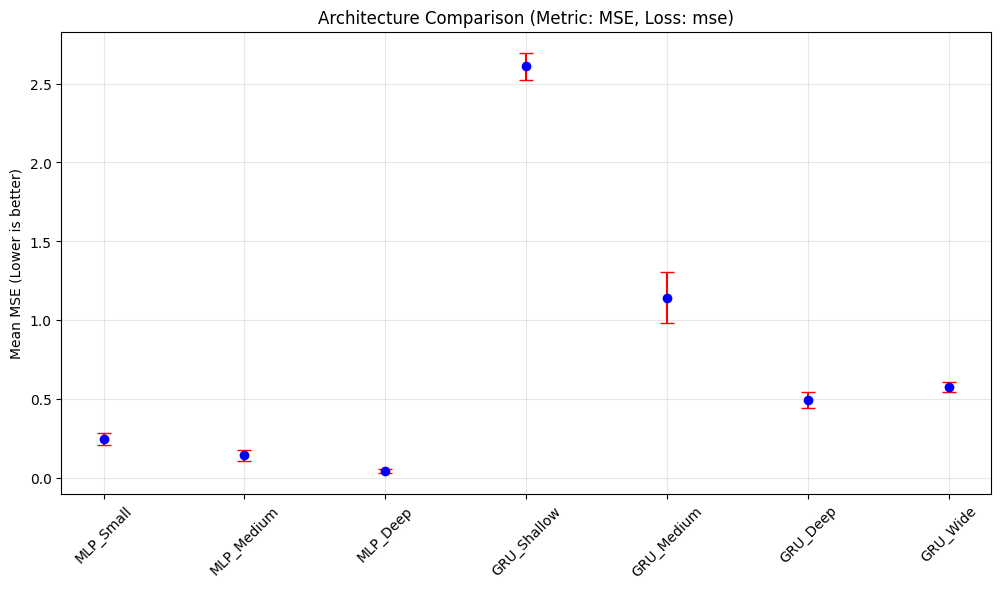


=== PHASE 2 RANKING ===
Architecture  Mean MSE  Std Dev
    MLP_Deep  0.044545 0.010636
  MLP_Medium  0.143411 0.036318
   MLP_Small  0.246226 0.037386
    GRU_Deep  0.494812 0.050738
    GRU_Wide  0.577466 0.030321
  GRU_Medium  1.140822 0.161673
 GRU_Shallow  2.608233 0.088205


In [9]:
BEST_LOSS = 'mse'

archi_configs = {
    'MLP_Small':   {'class': MLP, 'params': {'hidden_dims': [64, 32]}, 'dataset_type': 'mlp'},
    'MLP_Medium':  {'class': MLP, 'params': {'hidden_dims': [128, 64]}, 'dataset_type': 'mlp'}, # Baseline
    'MLP_Deep':    {'class': MLP, 'params': {'hidden_dims': [256, 128, 64, 32]}, 'dataset_type': 'mlp'},

    'GRU_Shallow': {'class': GRU, 'params': {'hidden_dim': 64,  'num_layers': 1}, 'dataset_type': 'rnn'},
    'GRU_Medium':  {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn'}, # Baseline
    'GRU_Deep':    {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 4}, 'dataset_type': 'rnn'},
    'GRU_Wide':    {'class': GRU, 'params': {'hidden_dim': 256, 'num_layers': 2}, 'dataset_type': 'rnn'},
}

archi_results = {}

for name, config in archi_configs.items():
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type=BEST_LOSS,
        n_runs=5,
        n_epochs=50
    )
    archi_results[name] = stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_viz = []
for name, stats in archi_results.items():
    data_viz.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df = pd.DataFrame(data_viz)

plt.figure(figsize=(12, 6))
# Plot with Error Bars
plt.errorbar(x=df['Architecture'], y=df['Mean MSE'], yerr=df['Std Dev'], fmt='o', capsize=5, ecolor='red', color='blue')
plt.title(f"Architecture Comparison (Metric: MSE, Loss: {BEST_LOSS})")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

print("\n=== PHASE 2 RANKING ===")
df_sorted = df.sort_values(by='Mean MSE')
print(df_sorted.to_string(index=False))